In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from funct_model_bias_TF import *
from indicators import *


In [2]:
#folder = "E:\python\data_boris\Hourly"
folder = "E:\python\data_MC"

In [3]:
import os
filelist = [file for file in os.listdir(folder) ]

In [4]:
symbols = [x[1:x.index("#C 1 Hour.txt")]  if ((x[0]  == "@")  |  (x[0]  == "Q")) else x[:x.index("#C 1 Hour.txt")] for x in filelist]

In [5]:
df = {i[1]: load_data_MC(i[0]) for i in zip(filelist,symbols)}    

In [6]:
year_start_train = 2006
year_end_train = 2018
years_train = range(year_start_train,year_end_train)
years_test = range(year_end_train,2021)

In [7]:
df_train = {symbol:train_test_split(df[symbol],years_train,years_test)[0] for symbol in symbols}
df_test  = {symbol:train_test_split(df[symbol],years_train,years_test)[1] for symbol in symbols}

In [8]:
import numpy as np
hour_list = {}
interval_list = {}
entry_time ={}
combination = {}
for symbol in symbols:
    x = df_train[symbol].HOURS.value_counts()
    hour_list[symbol] = np.sort(x[x>=x.quantile(0)].index.tolist())
    interval_list[symbol] = range(np.int(len(hour_list[symbol])/6),np.int(len(hour_list[symbol])/1.5))
    entry_time[symbol]  = [np.roll(hour_list[symbol],-hour_list[symbol].tolist().index(i))[0:j+1].tolist() for i in hour_list[symbol] for j in interval_list[symbol]]
    combination[symbol] = [[item1,item2,item3] for item1 in  entry_time[symbol] for item2 in range(5,35,5) for item3 in ['MR','BO','TF_MR','TF_BO']]

In [9]:
import funct_model_bias_TF
import time
start_time = time.time()

print("--- %s seconds ---" % (time.time() - start_time))
if __name__ == "__main__":
    import multiprocessing
    symbols
    pool = multiprocessing.Pool(8) 
    result1 = pool.map(funct_model_bias_TF.f_find_strategies_model_bias_TF, [[df_train,df_test,7,min_avg_trade[symbol],bpv[symbol],symbol,0,0,combination[symbol]] for symbol in symbols])
    #min_avg_trade[symbol]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---
--- 1219.8358614444733 seconds ---


In [10]:
SUMMARY ={symbols[i]:result1[i] for i in range(len(symbols))}
symbols = [i for i in symbols if len(SUMMARY[i])>0]
SUMMARY = {symbol:SUMMARY[symbol] for symbol in symbols}

In [11]:
#SUMMARY

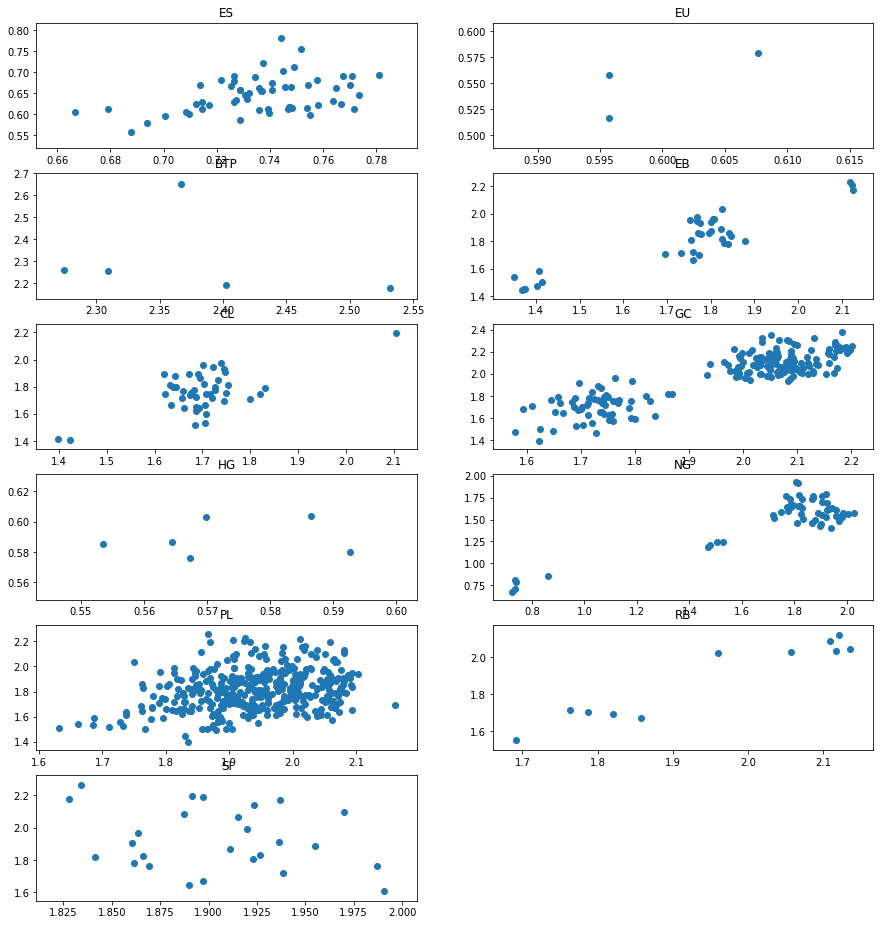

In [12]:
# Comparing IS and OS CALMAR

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,30))
for i in range(0,len(symbols)):
    fig.add_subplot(11,2, i+1)
    plt.scatter(SUMMARY[symbols[i]].PF_2_IS.values,(SUMMARY[symbols[i]].PF_2_OS.values))
    plt.title(symbols[i])
    plt.tight_layout

In [13]:
ALL_CHRONO_IS_strategies,ALL_CHRONO_OS_strategies = merge_equity_lines(SUMMARY,symbols,df_train,df_test,'1h')#'15min'

In [14]:
#plt.plot(SUMMARY['@AD'].OS_strat[2].cumsum())

In [15]:
corr_IS = {symbol:ALL_CHRONO_IS_strategies[symbol].corr(method = 'pearson') for symbol in symbols}
corr_OS = {symbol:ALL_CHRONO_OS_strategies[symbol].corr(method = 'pearson') for symbol in symbols}

In [16]:
list_to_keep = create_uncorrelated_list_of_strategies(SUMMARY,ALL_CHRONO_IS_strategies,corr_IS,symbols,0.5)

In [17]:
metric_type = ['Calmar_IS','PF_1_IS','PF_2_IS','PF_3_IS','Avg_trade_IS','standard']
tot = {i:{symbol:ALL_CHRONO_OS_strategies[symbol][list_to_keep[symbol][i][0]].sum(1) for symbol in symbols} for i in range(len(metric_type))}
tot_pd = pd.DataFrame([])
for symbol in symbols:
    tot_pd[symbol] = (tot[0][symbol]) 

8.55
8.51
6.17
6.5
8.52
5.05


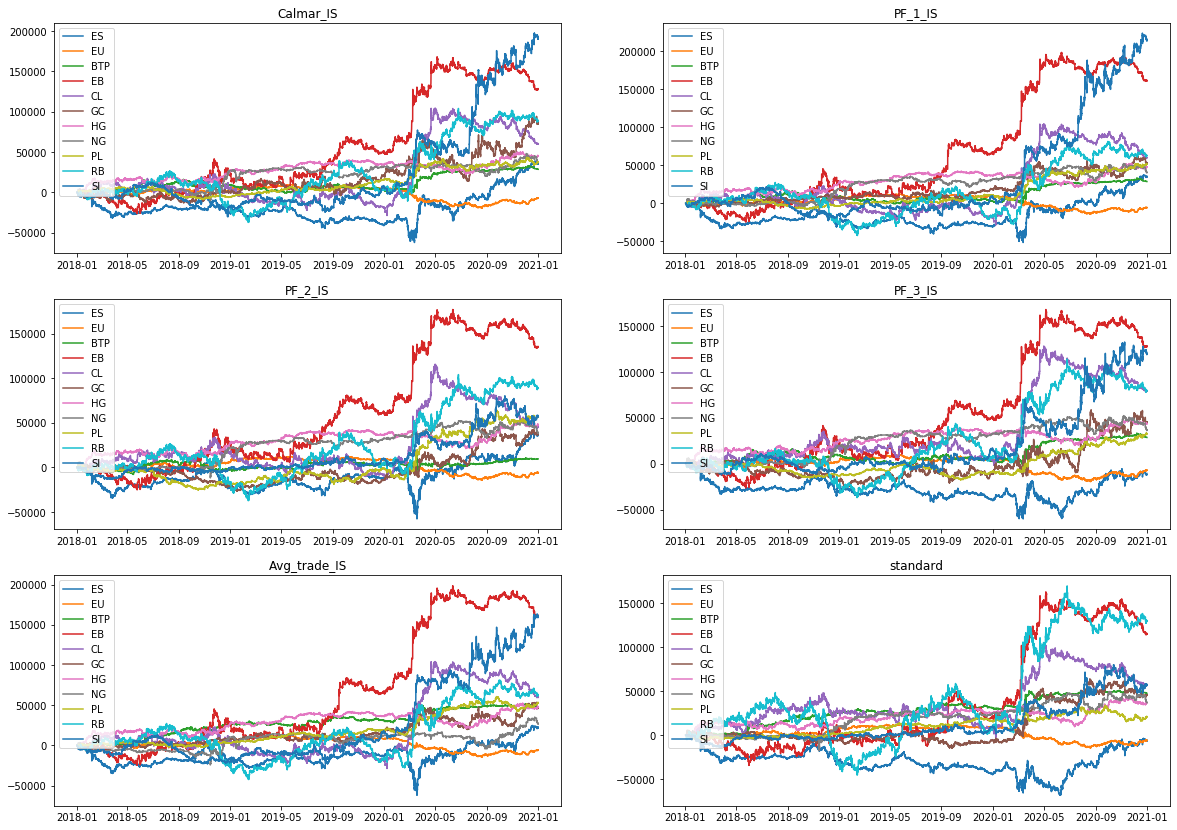

In [18]:
fig = plt.figure(figsize=(20,50))
for i in range(6):
    tot = {symbol:ALL_CHRONO_OS_strategies[symbol][list_to_keep[symbol][i][0]].sum(1) for symbol in symbols}
    tot_pd = pd.DataFrame([])
    fig.add_subplot(10,2, i+1)
    for symbol in symbols:
        tot_pd[symbol] = (tot[symbol])  #tot['@CL'].cumsum().plot()
    plt.plot(tot_pd.cumsum())#.plot()
    plt.legend(tot_pd.columns,loc='upper left')
    print(calmar(tot_pd.sum(1)))
    plt.title(metric_type[i])
    plt.tight_layout

In [19]:
IS_metric_w,OS_metric_w,weights = calc_weighted_strat(ALL_CHRONO_IS_strategies,ALL_CHRONO_OS_strategies,list_to_keep,metric_type,symbols,'max_draw')

Calmar_IS
7.94
PF_1_IS
7.74
PF_2_IS
5.28
PF_3_IS
6.22
Avg_trade_IS
7.92
standard
5.59


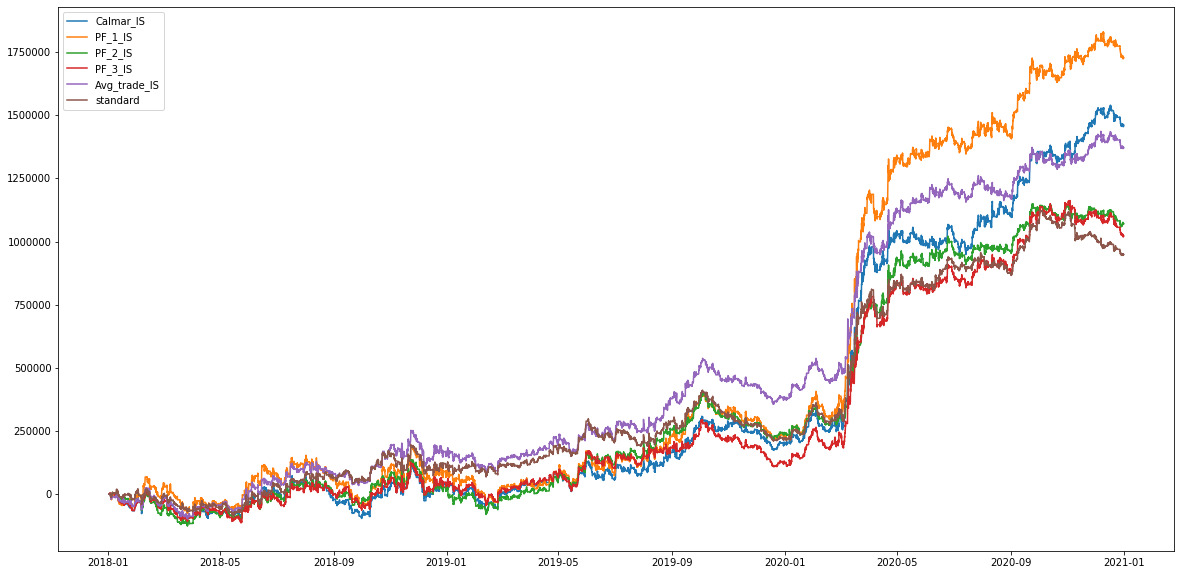

In [20]:
fig = plt.figure(figsize=(20,10))
for j in range(len(metric_type)):
    print(metric_type[j])
    print(calmar(OS_metric_w[metric_type[j]].sum(1)))
    plt.plot(OS_metric_w[metric_type[j]].sum(1).cumsum(),label=metric_type[j] )
    plt.legend(loc = 'upper left')

In [38]:
list_to_keep['PL'][1][0]

[172]

In [71]:
SUMMARY['EB'].iloc[list_to_keep['EB'][1][0]]['comb'].iloc[2]

[[10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 0, 1], 15, 'TF_BO']

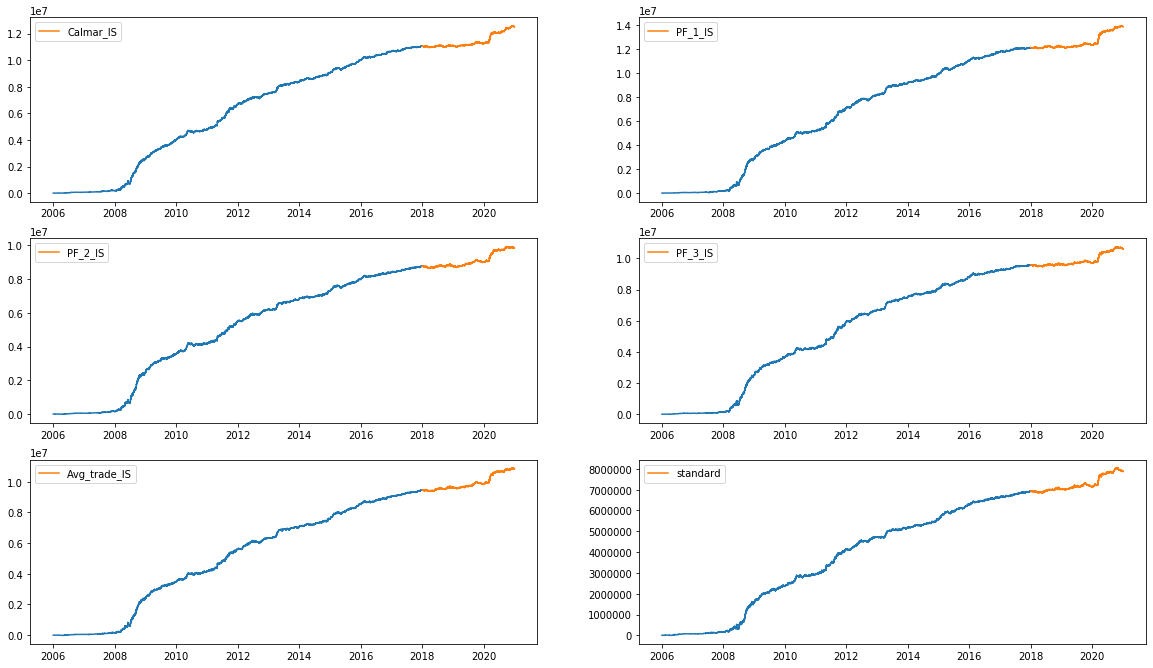

In [21]:
# Show IS-OS aggregate equity lines 

fig = plt.figure(figsize=(20,40))
for metric in metric_type:
    fig.add_subplot(10,2, metric_type.index(metric)+1)
    plt.plot(IS_metric_w[metric].sum(1).cumsum())
    #plt.plot(IS_final_tot[metric].cumsum())
    plt.plot(IS_metric_w[metric].sum(1).sum()+OS_metric_w[metric].sum(1).cumsum(),label=metric)
    plt.legend()

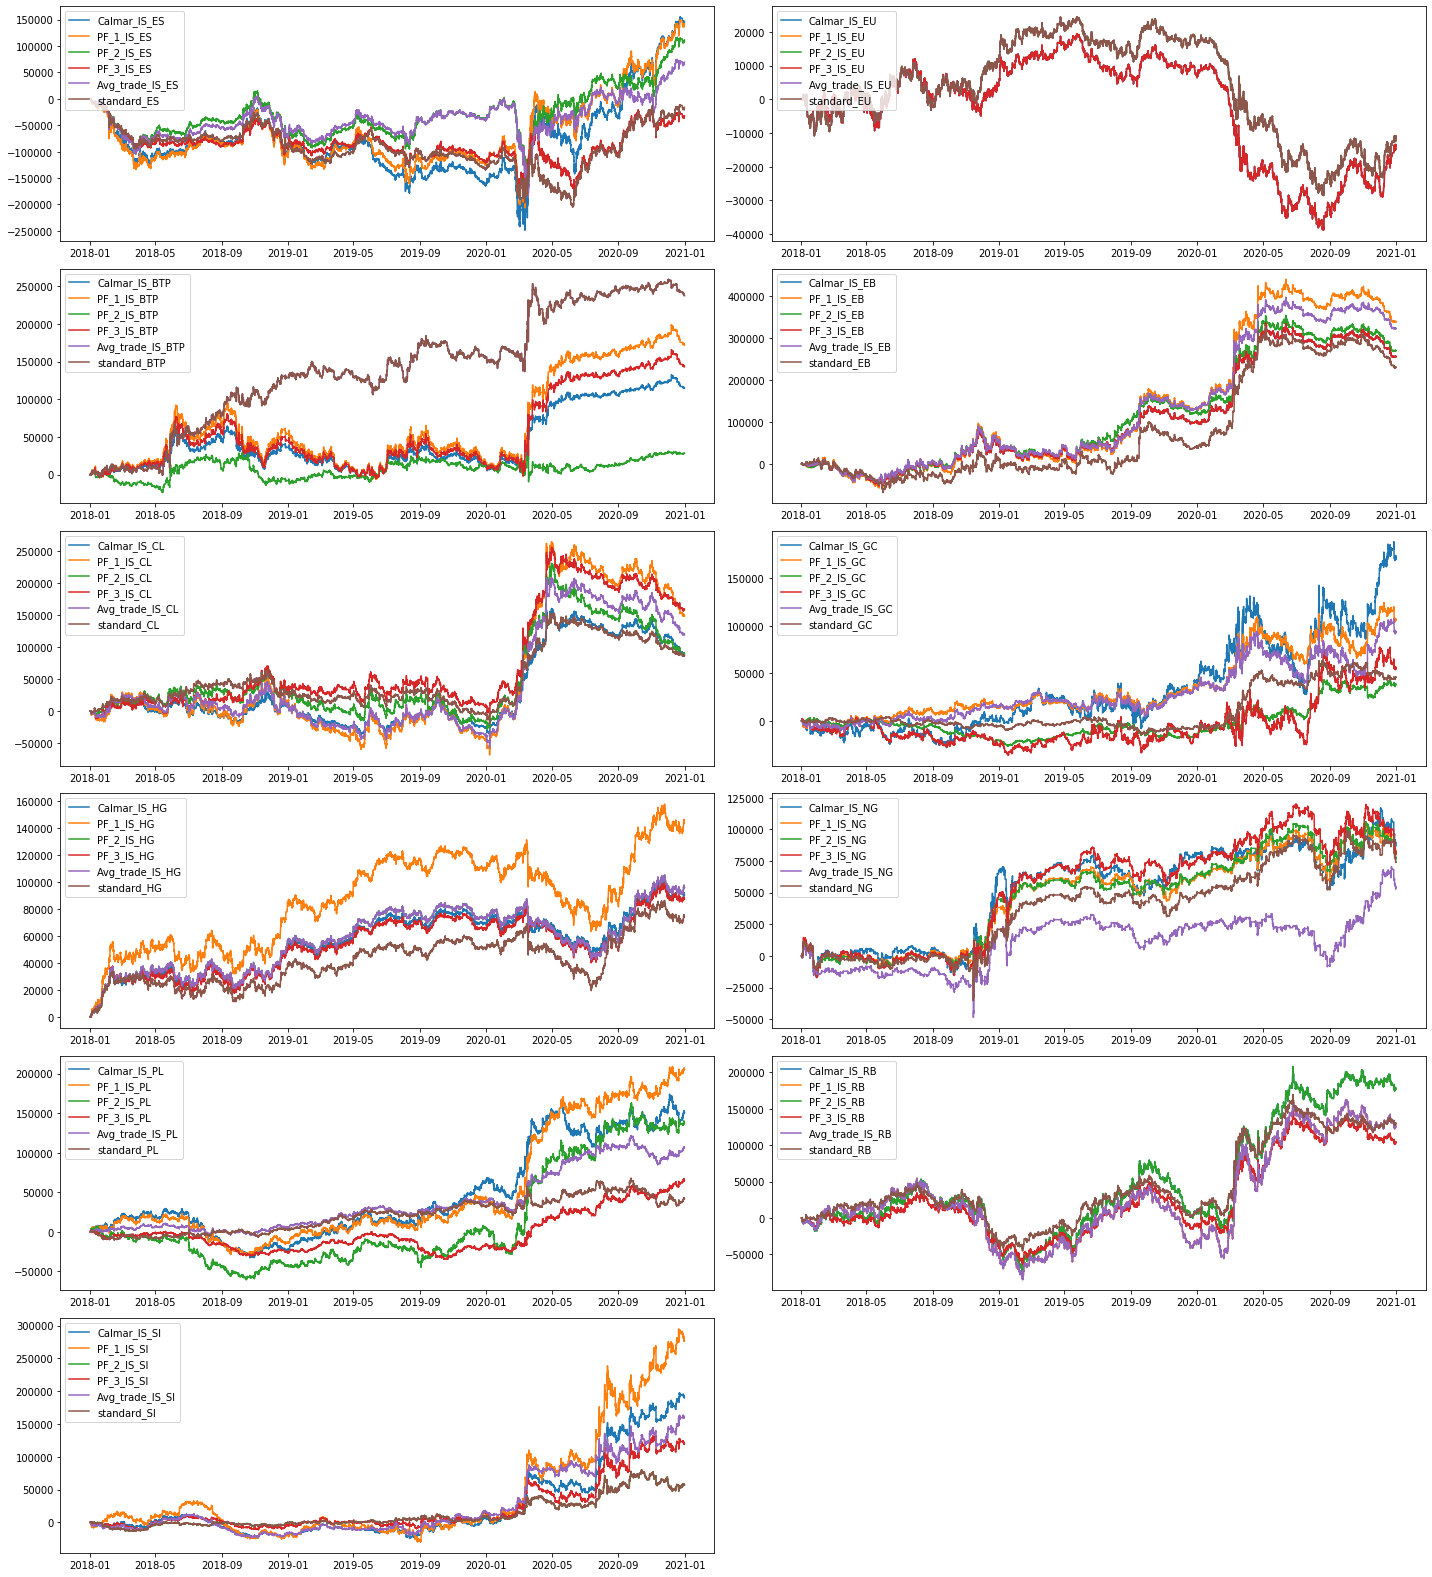

In [22]:
# Show aggregate result for each symbol and for different metrics

fig = plt.figure(figsize=(20,40))
for symbol in symbols:
    fig.add_subplot(11,2, symbols.index(symbol)+1)
    for metric in metric_type:
        plt.plot(OS_metric_w[metric][symbol].sum(1).cumsum(),label=metric+'_'+symbol)
        plt.legend(loc = 'upper left')
    plt.tight_layout()




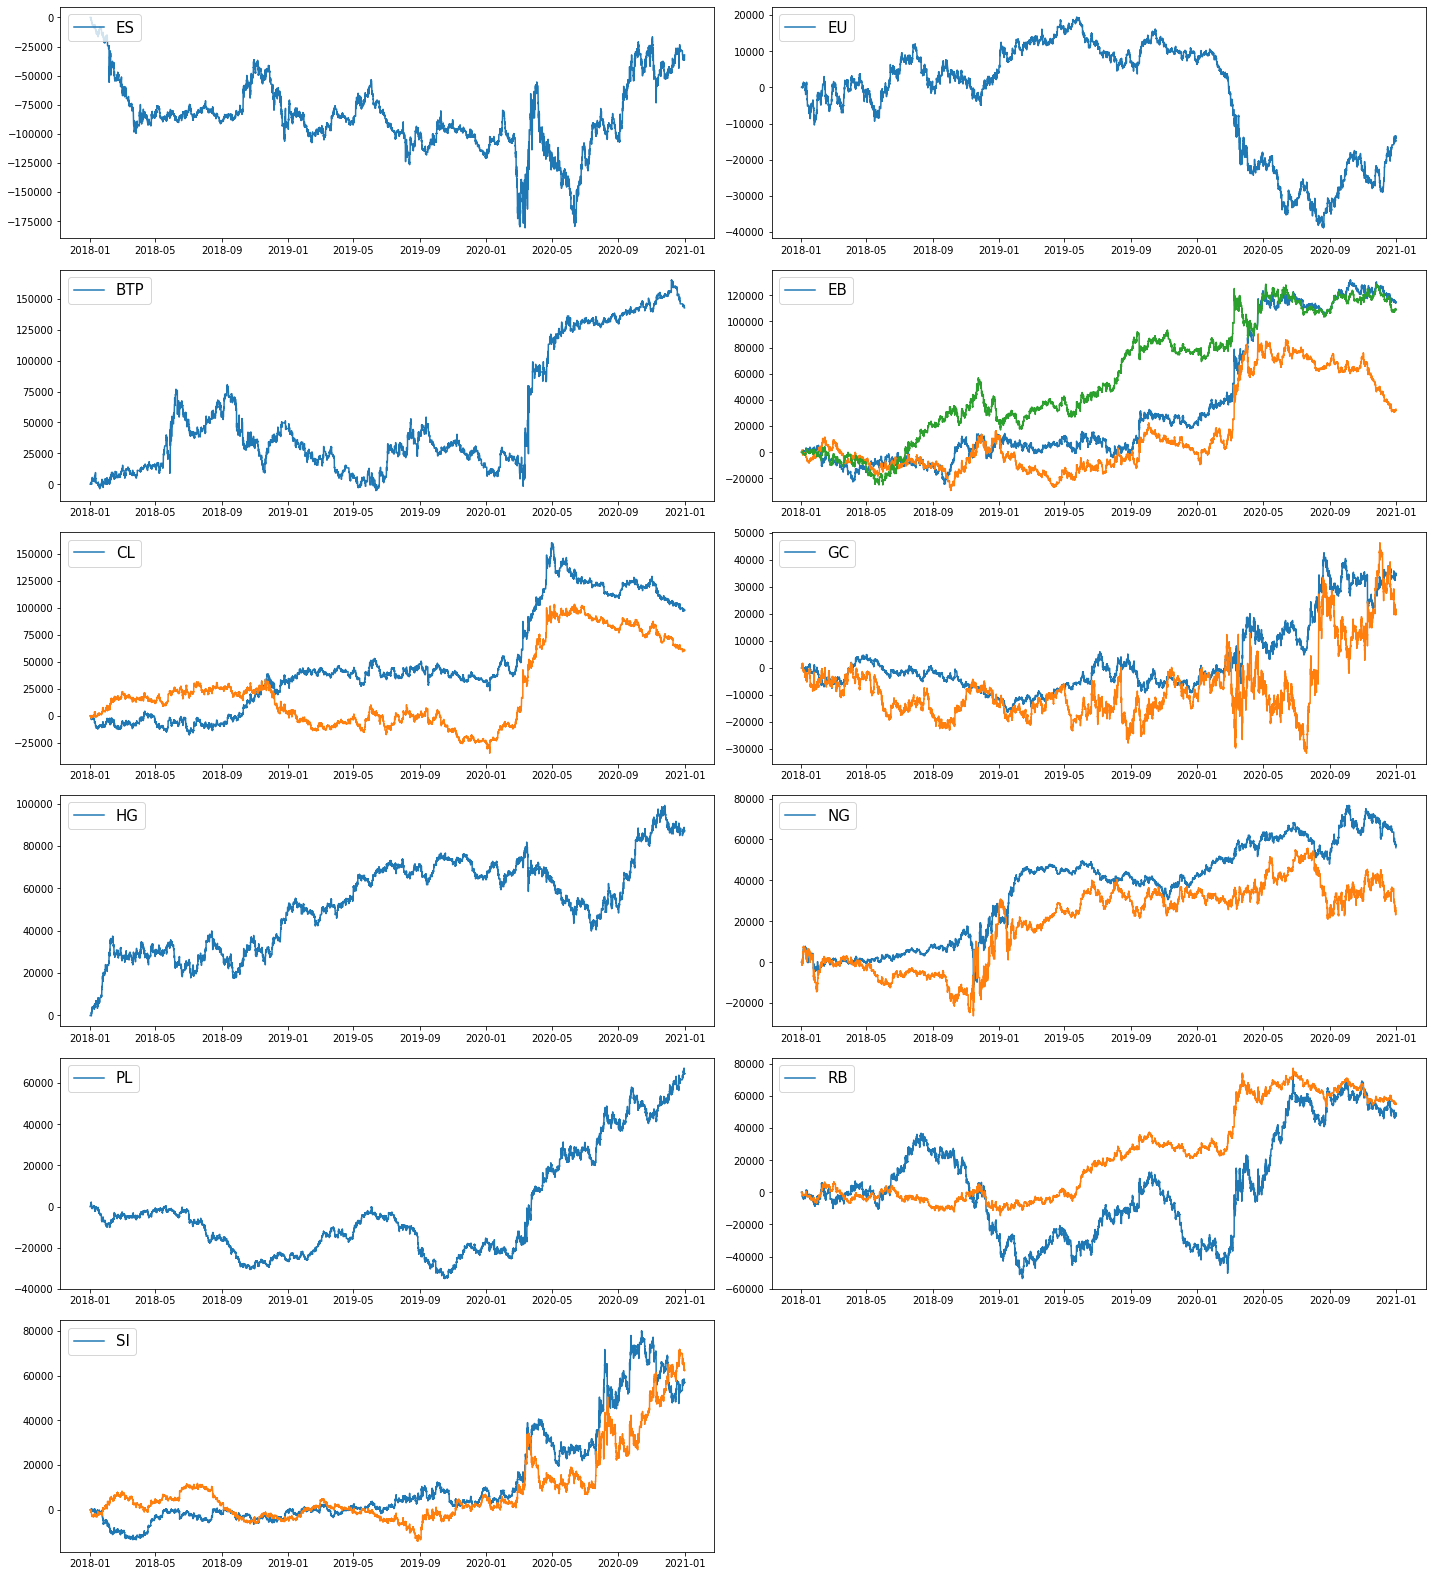

In [23]:
# Show the elementary strategies for each symbol and for a specific metric

fig = plt.figure(figsize=(20,40))
for symbol in symbols:
    fig.add_subplot(11,2, symbols.index(symbol)+1)
    plt.plot(OS_metric_w['PF_3_IS'][symbol].cumsum())
    #OS_metric_w[metric_type[0]][symbol].sum(1).cumsum().plot()
    plt.legend([symbol],fontsize=15,loc = 2)
    plt.tight_layout()


In [24]:
def sharpe(strategies):
    sharpe = strategies.mean()/strategies.std()
    return sharpe

In [25]:
sharpe(IS_metric_w['PF_2_IS'].resample('1D').sum())*np.sqrt(250)

for metric in metric_type:
    print(metric)
    print(sharpe(OS_metric_w[metric].sum(1).resample('1D').sum())*np.sqrt(250))

Calmar_IS
1.402810133166721
PF_1_IS
1.4391707180777082
PF_2_IS
1.1649605118243735
PF_3_IS
1.0492573352117822
Avg_trade_IS
1.4328595413408067
standard
1.1120584219332397


In [26]:
#df = df['XG']
model_bias_TF(df_train['XG'],combination['XG'][0],1,0).pl

array([ -0. ,  -0. ,   0. , ...,   3.5, -10.5, -20. ])